In [1]:
'''
04/30 update:
1. Re-split dataset to train:val:test = 80:10:10; updated results based on the new split
2. Updated to be able to predict X_test directly
3. Added sections and re-organized cells

04/29 update:
1. Removed the Year column for training
2. Used only data in Year 2021 and onward for training
3. Included 12hr moving average as an additional feature
4. Changed model #2 from LinearSVC to SVC (rbf kernel) since the linear one failed to converge

04/27 update:
1. Updated Cell 6
2. Added data exploration, undersampling
3. Preliminary modeling and model eval
4. Saved models

04/26 update:
1. Added Cell 6

'''

'\n04/27 update:\n1. Updated Cell 6\n2. Added data exploration, undersampling\n3. Preliminary modeling and model eval\n4. Saved models\n\n04/26 update:\n1. Added Cell 6\n\n'

#### 1. Load Dataset

In [1]:
import pandas as pd
import datetime

dt = datetime.datetime

In [2]:
def removeUTC(date_string):
    '''
    Removes the +00 in UTC datetime string
    '''
    return date_string.split("+")[0]

In [3]:
df = pd.read_csv("C:\\Users\\ASUS\\Desktop\\DATA245\\EVCS_Energy.csv.csv")

# dropping all rows with NaN
df.dropna(inplace=True)

####
#### 2. Data Cleaning

In [4]:
df = df.reset_index()
threshold = pd.Timedelta(hours=96)
rows_to_drop = []


for idx, _ in df.iterrows():
    
    start_time = pd.to_datetime(df.iloc[idx]['Start_Date___Time'])
    end_time = pd.to_datetime(df.iloc[idx]['End_Date___Time'])
    
    if (end_time - start_time) >= threshold:
        rows_to_drop.append(idx)
        continue
    
    duration = pd.to_timedelta(df.iloc[idx]['Total_Duration__hh_mm_ss_'])
    
    if ((end_time - start_time) - duration) > pd.Timedelta(minutes=1):
        rows_to_drop.append(idx)

df = df.drop(rows_to_drop)

In [5]:
# creating a dictionary for storing station information for easier access
station_names = set(df['Station_Name'])
zeros = [0]*len(station_names)

station_dict = dict(zip(station_names, zeros))
# station_dict

In [6]:
split_sessions = []
df_hourly_col = ['Station_Name', 'Address', 'City', 'State_Province', 'Zip','Year', 'Month', 'Date', 'DayOfWeek','Start_Hour', 'Minutes_Occupied_Per_Hour']

# increments time by 1 hour
delta = datetime.timedelta(hours=1)

for idx, session in df.iterrows():
    
    # calculating start and end times for each session
    start_time = dt.strptime(removeUTC(session['Start_Date___Time']), '%Y/%m/%d %H:%M:%S')
    end_time = dt.strptime(removeUTC(session['End_Date___Time']), '%Y/%m/%d %H:%M:%S')
    station = session['Station_Name']
    # print(station, start_time, end_time)
    
    # updating the station_dict info for every new station
    if station_dict[station] == 0:
        station_dict[station] = {
            'address': session['Address'],
            'city': session['City'],
            'state': session['State_Province'],
            'zip': session['Zip_Postal_Code']
        }
    
    station_info = (station, station_dict[station]['address'], station_dict[station]['city'], station_dict[station]['state'], station_dict[station]['zip'])
    
    current_time = start_time
    while not current_time > end_time:
        # print(current_time)
        
        # Handling edge case for start and end time in the same hour
        if start_time.replace(minute=0, second=0) == end_time.replace(minute=0, second=0):
            split_sessions.append(station_info + (start_time.year, start_time.month, start_time.day, start_time.isoweekday(),start_time.hour, (end_time - start_time).seconds / 60))
            current_time += delta
        
        # Getting occupancy rate for first hour of session
        elif current_time == start_time:
            rightbound = start_time.replace(minute=0, second=0) + delta
            split_sessions.append(station_info + (start_time.year, start_time.month, start_time.day, start_time.isoweekday(),start_time.hour, (rightbound - start_time).seconds / 60))
            current_time = rightbound
        
        # Getting occupancy for last hour of session
        elif current_time >= end_time.replace(minute=0, second=0):
            leftbound = end_time.replace(minute=0, second=0)
            split_sessions.append(station_info + (end_time.year, end_time.month, end_time.day, end_time.isoweekday(), end_time.hour, (end_time - leftbound).seconds / 60))
            current_time += delta
        
        else:
            split_sessions.append(station_info + (current_time.year, current_time.month, current_time.day, current_time.isoweekday(), current_time.hour, 60))
            current_time += delta
        
# create a new DataFrame from the split sessions
df_split = pd.DataFrame(split_sessions, columns=df_hourly_col)

df_split
# df_split.info()

,Station_Name,Address,City,State_Province,Zip,Year,Month,Date,DayOfWeek,Start_Hour,Minutes_Occupied_Per_Hour
0,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2018,1,20,6,7,31.0
1,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2018,1,20,6,8,60.0
2,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2018,1,20,6,9,22.0
3,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2018,2,9,5,16,3.0
4,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2018,2,9,5,17,60.0
...,...,...,...,...,...,...,...,...,...,...,...
208957,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2023,3,31,5,6,1.0
208958,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2023,3,31,5,7,60.0
208959,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2023,3,31,5,8,60.0
208960,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2023,3,31,5,9,60.0


In [7]:
# create a new dataframe with all possible combinations of Station_Name, Year, Month, Date, and Hour
date_range = pd.date_range(start=df['Start_Date___Time'].min(), end=df['End_Date___Time'].max())
hours = range(0, 24)
all_times = []
columns = ['Station_Name', 'Address', 'City', 'State_Province', 'Zip','Year', 'Month', 'Date', 'DayOfWeek','Start_Hour', 'Minutes_Occupied_Per_Hour']

# Generating complete timeseries for all charging stations
for station in station_dict:
    station_info = (station, station_dict[station]['address'], station_dict[station]['city'], station_dict[station]['state'], station_dict[station]['zip'])
    
    for date in date_range:
        for hour in hours:
            all_times.append(station_info+(date.year, date.month, date.day, date.isoweekday(), hour, 0))
        

total_time_df = pd.DataFrame(all_times, columns=columns)
#total_time_df.info()

In [8]:
# merge the original dataframe with the new dataframe to fill in missing hours and dates
concat_df = pd.concat([total_time_df, df_split], ignore_index=True)
#concat_df.info()

# Summing up Minutes_Occupied_Per_Hour for each station
final_df = concat_df.groupby(concat_df.columns[:-1].tolist()).sum().reset_index()
#final_df.info()

# Compute occupation rate
final_df['NumberOfPorts'] = 2
final_df['OccupationRate'] = (final_df['Minutes_Occupied_Per_Hour']/60)/final_df['NumberOfPorts']*100.00

# Sanity check
final_df[final_df['OccupationRate'] > 100]

,Station_Name,Address,City,State_Province,Zip,Year,Month,Date,DayOfWeek,Start_Hour,Minutes_Occupied_Per_Hour,NumberOfPorts,OccupationRate


In [9]:
# Select relevant features and time frame to work with
final_df = final_df[['Station_Name', 'Year', 'Month', 'Date', 'DayOfWeek','Start_Hour', 'OccupationRate']].loc[final_df['Year'].ge(2021)]
final_df

,Station_Name,Year,Month,Date,DayOfWeek,Start_Hour,OccupationRate
26304,BOULDER / AIRPORT ST1,2021,1,1,5,0,0.0
26305,BOULDER / AIRPORT ST1,2021,1,1,5,1,0.0
26306,BOULDER / AIRPORT ST1,2021,1,1,5,2,0.0
26307,BOULDER / AIRPORT ST1,2021,1,1,5,3,0.0
26308,BOULDER / AIRPORT ST1,2021,1,1,5,4,0.0
...,...,...,...,...,...,...,...
1473029,COMM VITALITY / BOULDER JCTN,2023,4,2,7,19,0.0
1473030,COMM VITALITY / BOULDER JCTN,2023,4,2,7,20,0.0
1473031,COMM VITALITY / BOULDER JCTN,2023,4,2,7,21,0.0
1473032,COMM VITALITY / BOULDER JCTN,2023,4,2,7,22,0.0


####
#### 3. Data Exploration

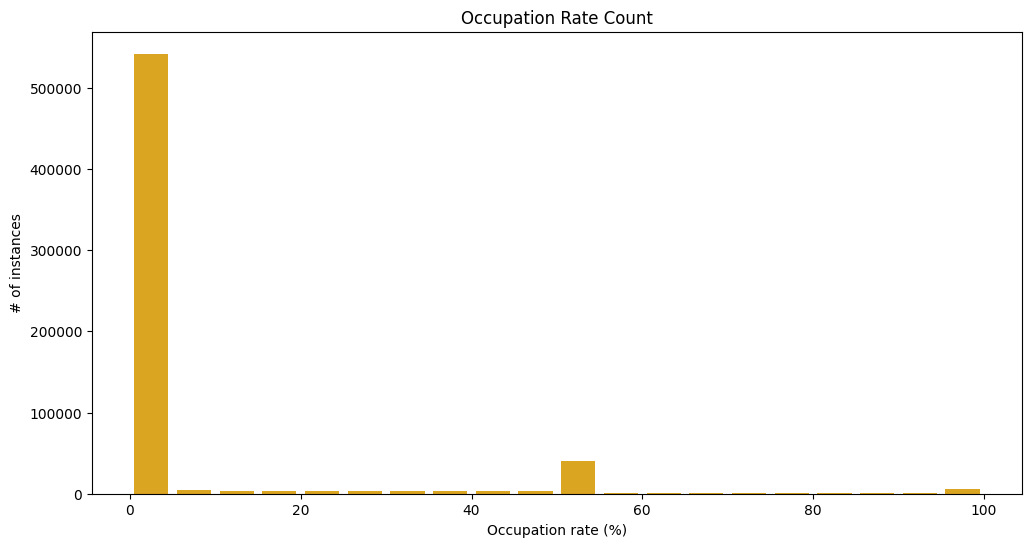

In [10]:
# Instance count plot
import matplotlib.pyplot as plt

plt.figure(figsize =(12, 6))
n, bins, _ = plt.hist(final_df[['OccupationRate']], bins=20, range=(0, 100), color='goldenrod', rwidth=0.8)
plt.ylabel('# of instances')
plt.xlabel('Occupation rate (%)') 
plt.title('Occupation Rate Count')
plt.show()

In [11]:
# Instance count
pd.DataFrame(data=n, index=[str(bins[i])+' - '+str(bins[i+1]) for i in range(len(bins)-1)], columns=['Instance count'], dtype='int')

,Instance count
0.0 - 5.0,542027
5.0 - 10.0,4007
10.0 - 15.0,3967
15.0 - 20.0,3824
20.0 - 25.0,3826
25.0 - 30.0,3895
30.0 - 35.0,3848
35.0 - 40.0,3750
40.0 - 45.0,3550
45.0 - 50.0,3763


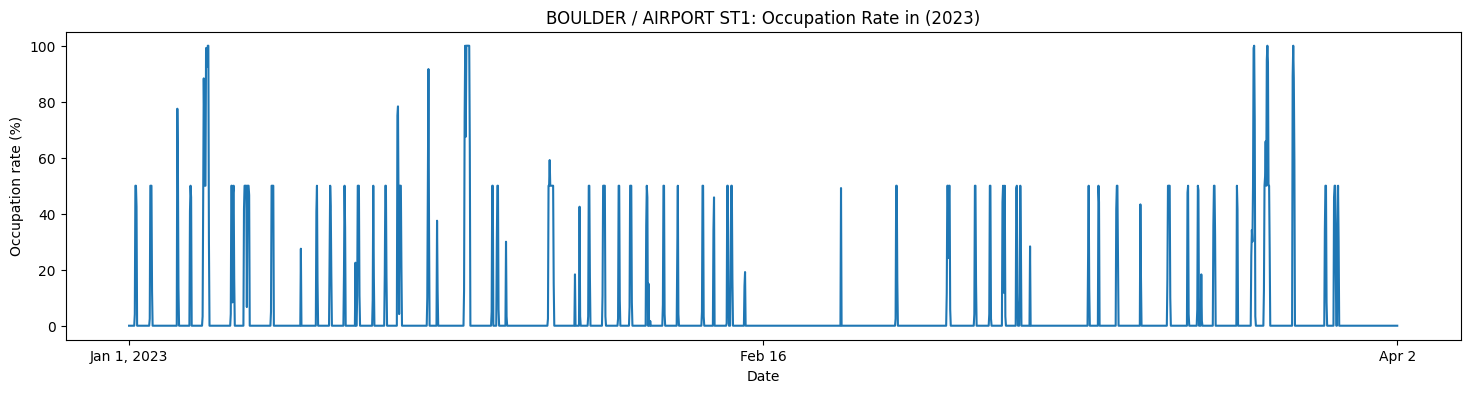

In [12]:
# Sample occupation rate plot
y = final_df[(final_df['Station_Name'] == 'BOULDER / AIRPORT ST1') & (final_df['Year'].eq(2023))]['OccupationRate']
x = [t for t in range(len(y))]

plt.figure(figsize=(18, 4))
plt.plot(x, y)
plt.ylabel('Occupation rate (%)')
plt.xlabel('Date')
plt.xticks(ticks=[x[0], x[len(x)//2], x[-1]], labels=['Jan 1, 2023', 'Feb 16', 'Apr 2'])
plt.title('BOULDER / AIRPORT ST1: Occupation Rate in (2023)')
plt.show()

####
#### 4. Data Transformation

##### 4-1. 12-hr moving average

In [14]:
# Compute 12hr moving average
final_df = final_df.sort_values(by=['Station_Name', 'Year', 'Month', 'Date', 'Start_Hour'])
final_df = final_df.reset_index(drop=True)
final_df['12hr_MA'] = 0.0
final_df

,Station_Name,Year,Month,Date,DayOfWeek,Start_Hour,OccupationRate,12hr_MA
0,BOULDER / AIRPORT ST1,2021,1,1,5,0,0.0,0.0
1,BOULDER / AIRPORT ST1,2021,1,1,5,1,0.0,0.0
2,BOULDER / AIRPORT ST1,2021,1,1,5,2,0.0,0.0
3,BOULDER / AIRPORT ST1,2021,1,1,5,3,0.0,0.0
4,BOULDER / AIRPORT ST1,2021,1,1,5,4,0.0,0.0
...,...,...,...,...,...,...,...,...
631301,COMM VITALITY / BOULDER JCTN,2023,4,2,7,19,0.0,0.0
631302,COMM VITALITY / BOULDER JCTN,2023,4,2,7,20,0.0,0.0
631303,COMM VITALITY / BOULDER JCTN,2023,4,2,7,21,0.0,0.0
631304,COMM VITALITY / BOULDER JCTN,2023,4,2,7,22,0.0,0.0


In [15]:
# Compute 12hr moving average
from statistics import mean

k = 0
for i in range(1, len(final_df)):
    
    if final_df.at[i, 'Station_Name'] != final_df.at[i-1, 'Station_Name']:
        k = i
        continue
        
    if i-k < 12:
        final_df.at[i, '12hr_MA'] = mean([final_df['OccupationRate'].loc[j] for j in range(i-1, k-1, -1)])
    else:
        final_df.at[i, '12hr_MA'] = mean([final_df['OccupationRate'].loc[j] for j in range(i-1, i-13, -1)])  
        

In [16]:
# Format features and construct features/target dataframes
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Features dataframe
ohe = OneHotEncoder()
features = final_df[['Station_Name', 'Month', 'Date', 'DayOfWeek','Start_Hour']]
features = pd.DataFrame(ohe.fit_transform(features).toarray())
features[106] = final_df['12hr_MA']

# Target dataframe
target = pd.DataFrame()
target['Available_spot?'] = np.where(final_df['OccupationRate'] >= 50, 1, 0)

features.head()
# target.head()

,0,1,2,3,4,5,6,7,8,9,...,97,98,99,100,101,102,103,104,105,106
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Target class statistics
c0 = target[target['Available_spot?'] == 0].count()[0]
c1 = target[target['Available_spot?'] == 1].count()[0]

print(f"    Likely to get a spot (Class 0): {c0:8} instances")
print(f"Not likely to get a spot (Class 1): {c1:8} instances")

    Likely to get a spot (Class 0):   576457 instances
Not likely to get a spot (Class 1):    54849 instances


##### 4-2. Undersampling

In [18]:
# Class count before undersampling
from collections import Counter

counter = Counter(target['Available_spot?'])
print('Before undersampling:', counter)

Before undersampling: Counter({0: 576457, 1: 54849})


In [19]:
# Random undersampling
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=11)
features, target = rus.fit_resample(features, target)

# Class count after undersampling
counter = Counter(target['Available_spot?'])
print('After undersampling:', counter)

After undersampling: Counter({0: 54849, 1: 54849})


In [ ]:
'''

### Using OSS undersamling could potentially increase performance but it's currently taking too long to run ###



# One-Sided Selection (OSS) undersampling
from imblearn.under_sampling import OneSidedSelection

undersample = OneSidedSelection(n_neighbors=1, n_seeds_S=200, random_state=11)
features, target = undersample.fit_resample(features, target)

# Class count after undersampling
counter = Counter(target)
print('After undersampling:', counter)

'''

####
#### 5. Modeling and Evaluation

In [20]:
# Train-test split
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(features.to_numpy(), target.to_numpy().flatten(), test_size=0.1, random_state=11)

X_train, X_test, y_train, y_test = train_test_split(features.to_numpy(), target.to_numpy().flatten(), test_size=0.2, random_state=11)
X_test, X_val, y_test, y_val  = train_test_split(X_test, y_test, test_size=0.5, random_state=11)

##### 5-1. Logistic regression

In [21]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, random_state=11)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

In [22]:
# Model evaluation
from sklearn.metrics import confusion_matrix, classification_report

print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_lr))
print()
print(classification_report(y_test, y_pred_lr, target_names=['Likely to get a spot (Class 0)', 'Not likely to get a spot (Class 1)']))

Confusion matrix:
[[4606  837]
 [ 860 4667]]

                                    precision    recall  f1-score   support

    Likely to get a spot (Class 0)       0.84      0.85      0.84      5443
Not likely to get a spot (Class 1)       0.85      0.84      0.85      5527

                          accuracy                           0.85     10970
                         macro avg       0.85      0.85      0.85     10970
                      weighted avg       0.85      0.85      0.85     10970



##### 5-2. Support vector classifier

In [23]:
from sklearn.svm import SVC
svc = SVC(random_state=11)
svc.fit(X_train, y_train)

y_pred_svc = svc.predict(X_test)

In [24]:
# Model evaluation

print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_svc))
print()
print(classification_report(y_test, y_pred_svc, target_names=['Likely to get a spot (Class 0)', 'Not likely to get a spot (Class 1)']))

Confusion matrix:
[[4422 1021]
 [ 527 5000]]

                                    precision    recall  f1-score   support

    Likely to get a spot (Class 0)       0.89      0.81      0.85      5443
Not likely to get a spot (Class 1)       0.83      0.90      0.87      5527

                          accuracy                           0.86     10970
                         macro avg       0.86      0.86      0.86     10970
                      weighted avg       0.86      0.86      0.86     10970



##### 5-3. Random forest

In [25]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500, max_features='log2', max_depth=100, random_state=11)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

In [26]:
# Model evaluation

print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_rf))
print()
print(classification_report(y_test, y_pred_rf, target_names=['Likely to get a spot (Class 0)', 'Not likely to get a spot (Class 1)']))

Confusion matrix:
[[4576  867]
 [ 223 5304]]

                                    precision    recall  f1-score   support

    Likely to get a spot (Class 0)       0.95      0.84      0.89      5443
Not likely to get a spot (Class 1)       0.86      0.96      0.91      5527

                          accuracy                           0.90     10970
                         macro avg       0.91      0.90      0.90     10970
                      weighted avg       0.91      0.90      0.90     10970



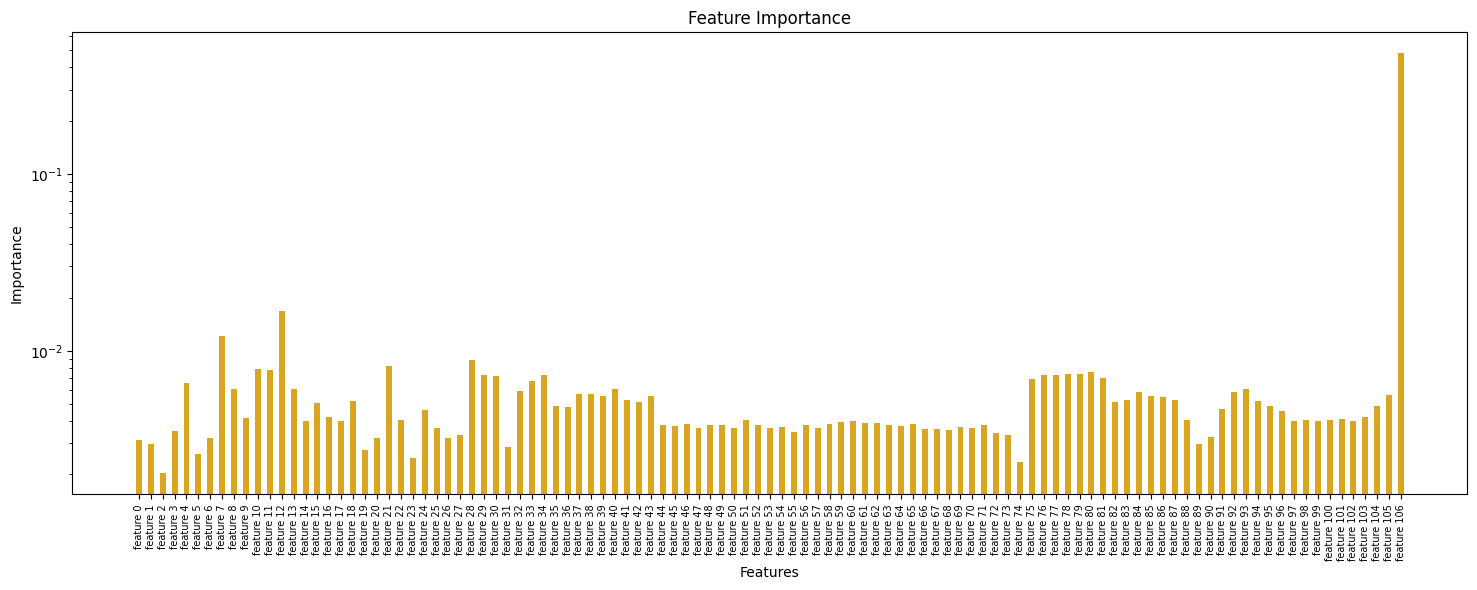

In [27]:
# Feature importance
imp = rf.feature_importances_

plt.figure(figsize =(18, 6))
plt.bar([f"feature {i}" for i in range(len(imp))], imp, color='goldenrod', width=0.5)
plt.ylabel('Importance')
plt.xlabel('Features') 
plt.xticks(rotation=90, fontsize=7)
plt.title('Feature Importance')
plt.yscale('log')
plt.show()

##### 5-4. kNN

In [28]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

In [29]:
# Model evaluation

print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_knn))
print()
print(classification_report(y_test, y_pred_knn, target_names=['Likely to get a spot (Class 0)', 'Not likely to get a spot (Class 1)']))

Confusion matrix:
[[4335 1108]
 [ 560 4967]]

                                    precision    recall  f1-score   support

    Likely to get a spot (Class 0)       0.89      0.80      0.84      5443
Not likely to get a spot (Class 1)       0.82      0.90      0.86      5527

                          accuracy                           0.85     10970
                         macro avg       0.85      0.85      0.85     10970
                      weighted avg       0.85      0.85      0.85     10970



##### 5-5. Naive Bayes

In [30]:
from sklearn.naive_bayes import GaussianNB

# Train the Naive Bayes model
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Make predictions on the test set
y_pred_gnb = gnb.predict(X_test)

# Model evaluation
from sklearn.metrics import confusion_matrix, classification_report

print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_gnb))
print()
print(classification_report(y_test, y_pred_gnb, target_names=['Likely to get a spot (Class 0)', 'Not likely to get a spot (Class 1)']))


Confusion matrix:
[[2295 3148]
 [ 333 5194]]

                                    precision    recall  f1-score   support

    Likely to get a spot (Class 0)       0.87      0.42      0.57      5443
Not likely to get a spot (Class 1)       0.62      0.94      0.75      5527

                          accuracy                           0.68     10970
                         macro avg       0.75      0.68      0.66     10970
                      weighted avg       0.75      0.68      0.66     10970



In [ ]:
####
#### 6. Deployment

##### 6-1. Save the trained models for future use

In [32]:
# Save the models to disk for future use
import pickle

pickle.dump(lr, open('lr_model.sav', 'wb'))
pickle.dump(svc, open('svc_model.sav', 'wb'))
pickle.dump(rf, open('rf_model.sav', 'wb'))
pickle.dump(knn, open('knn_model.sav', 'wb'))
pickle.dump(gnb, open('gnb_model.sav', 'wb'))

##### 6-2. Test the saved models using X_test and y_test

In [33]:
def available_spot(X_test, y_test, model='lr'):

    if model == 'lr':
        loaded_lr = pickle.load(open('lr_model.sav', 'rb'))
        result = loaded_lr.predict(X_test)
    elif model == 'svc':
        loaded_svc = pickle.load(open('svc_model.sav', 'rb'))
        result = loaded_svc.predict(X_test)
    elif model == 'rf':
        loaded_rf = pickle.load(open('rf_model.sav', 'rb'))
        result = loaded_rf.predict(X_test)
    elif model == 'knn':
        loaded_knn = pickle.load(open('knn_model.sav', 'rb'))
        result = loaded_knn.predict(X_test)
    else:
        raise Exception('Invalid model name')
    
    print('Model name:', model)
    print('Instance count:', len(X_test))
    print('\nConfusion matrix:')
    print(confusion_matrix(y_test, result))
    print()
    print(classification_report(y_test, result, target_names=['Likely to get a spot (Class 0)', 'Not likely to get a spot (Class 1)']))

In [34]:
# Logistic regression
available_spot(X_test, y_test, model='lr')

Row 1 - Prediction: Likely to get a spot (Class 0)


In [ ]:
# SVM
available_spot(X_test, y_test, model='svc')

In [ ]:
# Random forest
available_spot(X_test, y_test, model='rf')

In [ ]:
# KNN
available_spot(X_test, y_test, model='knn')